# Detect and track Rossby wave breaking by overturned potential-temperature contours on the dynamical tropopause

This recipe identifies and tracks overturning contours as a proxy for Rossby wave breaking. It smooths and identifies potential temperature overturned contours on the dynamical tropopause (2 PVU surface) at 5K intervals and tracks them by looking for zones which overlap. It can easily be tweaked to track potential vorticity on isentropic surfaces as in Barnes et. al. (2025)

References:<br>
Code based on and adapted from: Kaderli, S., 2023. WaveBreaking - Detection, Classification and Tracking of Rossby Wave Breaking. https://doi.org/10.5281/zenodo.14214463<br>
Used in: Barnes, M. A., M. J. Reeder, and T. Ndarana, 2025: Rossby wave breaking morphologies on the Southern Hemisphere dynamical tropopause. J. Climate, https://doi.org/10.1175/JCLI-D-24-0461.1, in press.

Load the python functions required for data handling

In [1]:
import os
import sys
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import subprocess
from tqdm import tqdm
from windspharm.xarray import VectorWind

Set and load the paths for your local WxSysLib installation.

In [2]:
os.environ["WXSYSLIBDIR"]='/g/data/gb02/mb0427/WxSysLib'
sys.path.append(os.environ["WXSYSLIBDIR"])

Set and load the Rossby wave breaking modules within WxSysLib

In [3]:
os.environ["RWBLIBDIR"]=f'{os.environ["WXSYSLIBDIR"]}/utils/blobs/WaveBreaking'
sys.path.append(os.environ["RWBLIBDIR"])

Import all the required WxSysLib functions (see WxSysLib documentation for details)

In [4]:
from utils.general.nci_utils import get_GADI_ERA5_filename
from utils.general.date_utils import generate_datetimes,generate_datetimes_months

from wavebreaking.processing.events import to_xarray, track_events
from wavebreaking.indices.contour_index import calculate_contours
from wavebreaking.indices.overturning_index import calculate_overturnings
from wavebreaking.additional_utils import process_to_geojson

In [5]:
print(calculate_overturnings.__doc__)


    Identify overturning structures based on the Overturning Index
    developed by Barnes and Hartmann (2012).
    The default parameters for the overturning identification
    are based on the study by Barnes and Hartmann (2012).
    The overturning region is represented by a rectangle
    enclosing all overturning contour points.
    Dimension names ("time_name", "lon_name", "lat_name"), size ("ntime", "nlon", "nlat")
    and resolution ("dlon", "dlat") can be passed as key=value argument.
    Before the index calculation, the contour lines are calculated if not provided.

    Parameters
    ----------
        data : xarray.DataArray
            data for the contour and overturning calculation
        contour_levels : array_like
            levels for contour calculation
        contours : geopandas.GeoDataFrame, optional
            contours calculated with wavebreaking.calculate_contours(...,
            original_coordinates=False)
        range_group : int or float, optional
   

Local settings 

sdt = starting month from ERA5 archive | default: datetime(1980,1,1)<br>
edt = starting month from ERA5 archive | default: datetime(1980,2,1)<br>
outpath = local path to write out output<br>
Tnum = Wave number to spectral truncation (required for smoothing data) | default: 21<br>
contour_levels = Contours to detect overturning on<br>
track_overlap_p = Percentage overlap to join objects in time | default: 25


In [5]:
sdt=datetime(1980,1,1)
edt=datetime(1980,2,1)
outpath='/scratch/if69/mb0427/RWB/test'
Tnum = 21
contour_levels=list(range(330,335,5))
track_overlap_p=25

Load the ERA5 data required and smooth by spectral truncation. NOTE: If you are using the GADI ERA5 archive, you must a be a member of uc16<br>
Find the defined contours and detect overturning zones. Write the output to a geojson file

In [6]:
first=True
for indt in generate_datetimes_months(sdt,edt,interval=1):
    indtstr=indt.strftime('%Y%m')
    print(f'Calculating overturning for {indtstr}')
    
    #Get the path for the ERA5 isentropic PV file on GADI
    ptfile=get_GADI_ERA5_filename('pt',indt,stream='hourly',level_type='potential-vorticity')
    ufile=get_GADI_ERA5_filename('u',indt,stream='hourly',level_type='potential-vorticity')
    vfile=get_GADI_ERA5_filename('v',indt,stream='hourly',level_type='potential-vorticity')

    #Resample the data to 6 hourly
    f_pt=xr.open_dataset(ptfile).resample(time='6H').nearest()#.isel(time=slice(0,5))
    f_u=xr.open_dataset(ufile).resample(time='6H').nearest()#.isel(time=slice(0,5))
    f_v=xr.open_dataset(vfile).resample(time='6H').nearest()#.isel(time=slice(0,5))

    #Smooth the data by spectral truncation
    all_pt_smooth=[]
    for t in tqdm(f_pt.time):
        VW = VectorWind(f_u.sel(time=t).u, f_v.sel(time=t).v,legfunc='computed')
        pt_smooth = VW.truncate(f_pt.sel(time=t).pt.expand_dims('time'), truncation=Tnum)
        all_pt_smooth.extend(pt_smooth)
    pt_smooth = xr.concat(all_pt_smooth, dim='time')

    #Retrieve the contours needed to check for overturning
    contours = calculate_contours(data=pt_smooth,
                                     contour_levels=contour_levels,
                                     periodic_add=120, # Add additional longitude band onto a periodic boundary
                                     original_coordinates=False) # optional

    #Check for overturnings [use print(calculate_overturnings.__doc__) for details]
    overturnings = calculate_overturnings(data=pt_smooth,
                                             contour_levels=contour_levels,
                                             contours=contours, #Precalculated contour object calculated by calculate_contours
                                             range_group=5, #Maximal degrees in the longitudinal direction in which two overturning are grouped
                                             min_exp=5, # Minimal longitudinal expansion of an overturning event
                                             periodic_add=120) # Add additional longitude band onto a periodic boundary

    #Save the output to a geojson file
    outfile=f'{outpath}/ERA5_2PVU_overturnings_6hrly_{indtstr}.geojson'
    process_to_geojson(overturnings,colnames=['com']).to_file(outfile, driver='GeoJSON')

Calculating overturning for 198001


INFO: HTTP Request: GET https://raw.githubusercontent.com/IrishMarineInstitute/awesome-erddap/master/erddaps.json "HTTP/1.1 200 OK"
Calculating overturnings: 100%|██████████| 248/248 [00:02<00:00, 88.29it/s] 
INFO: Created 239 records


Calculating overturning for 198002


Calculating overturnings: 100%|██████████| 232/232 [00:02<00:00, 95.38it/s] 
INFO: Created 198 records


Load all the required overturnings from the geojson files and concatenate them into a single dataframe.

In [7]:
concatenated_df=[]
for indt in generate_datetimes_months(sdt,edt,interval=1):
    indtstr=indt.strftime('%Y%m')
    
    infile = f'{outpath}/ERA5_2PVU_overturnings_6hrly_{indtstr}.geojson'
    indf = gpd.read_file(infile)
    if not indf.empty: 
        concatenated_df.append(indf)

concatenated_df = pd.concat(concatenated_df, ignore_index=True)

Track the overturning zones on each specified contour level by overlap and write the output to a geojson file

In [8]:
#Use print(track_events.__doc__) for details
for contour_level in contour_levels:
    tracked = track_events(events=concatenated_df[concatenated_df.level==contour_level],
                                    time_range=6, #time range for temporal tracking in hours
                                    method="by_overlap", #method for tracking ["by_overlap", "by_distance"]
                                    overlap=track_overlap_p/100, #Minimum percentage overlap should be [float between 0 and 1.0]
                                    overlap_by="smallest") #how overlap should be calculated ["union", "next", "smallest"]
    
    outfile=f"{outpath}/ERA5_2PVU_tracked_p{track_overlap_p}_{contour_level}K_overturnings_6hrly_{sdt.strftime('%Y%m')}-{edt.strftime('%Y%m')}.geojson"
    gpd.GeoDataFrame(tracked, geometry=tracked.geometry).to_file(outfile, driver='GeoJSON') 

100%|██████████| 437/437 [00:00<00:00, 29277.39it/s]


Overlaps


Merging groups: 100%|██████████| 361/361 [00:00<00:00, 1356759.63it/s]

Assign labels: 100%|██████████| 76/76 [00:00<00:00, 2262.44it/s]
INFO: Created 437 records


Smallest label....


Print out an example of the data. Track IDs are located in the column "label"

In [9]:
print(tracked.head())

                 date  level   mean_var  intensity  west_lat  east_lat  \
0 1980-01-01 00:00:00  330.0  330.22000        0.0    -52.50    -41.50   
3 1980-01-01 06:00:00  330.0  329.95999        0.0    -51.00    -43.00   
5 1980-01-01 12:00:00  330.0  328.38000        0.0    -49.50    -43.25   
7 1980-01-01 18:00:00  330.0  328.72000        0.0    -48.75    -42.00   
1 1980-01-01 00:00:00  330.0  329.23999        0.0    -36.50    -51.50   

   event_area   orientation   comX   comY  \
0  2876528.80  anticyclonic -53.75 -43.00   
3  2684390.80  anticyclonic -52.25 -41.75   
5  2466035.20  anticyclonic -50.00 -41.00   
7  2269870.00  anticyclonic -48.00 -41.00   
1   720305.81      cyclonic  57.25 -43.75   

                                            geometry  label  
0  POLYGON ((-45.5 -53, -45.5 -34, -61.75 -34, -6...      0  
3  POLYGON ((-45 -52, -45 -32.25, -59.25 -32.25, ...      0  
5  POLYGON ((-43.25 -51, -43.25 -31.75, -56.5 -31...      0  
7  POLYGON ((-41.75 -50.75, -41.75 -

Plot the climatology of the tracked objects using clim_xarray

In [10]:
from wavebreaking.processing.events import to_xarray,clim_xarray

In [11]:
# Load the grid one which overturning was detected. NOTE: Requires a time dimension to operate
ptfile = get_GADI_ERA5_filename('pt',datetime(1979,1,1),stream='hourly',level_type='potential-vorticity')
f_pt = xr.open_dataset(ptfile).resample(time='6H').nearest().pt#.isel(time=slice(0,1))

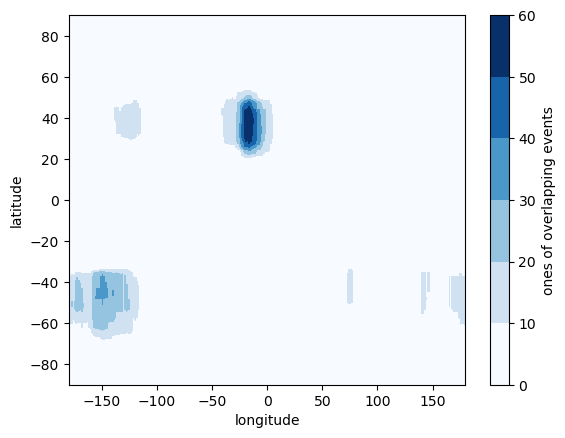

In [12]:
#Plot the wave breaking zones. 
#clim_xarray converts all of the RWB zone polygons to a given xarray grid and produces a 2D count 
#of all grid points on which RWB is located
data_flagged = clim_xarray(f_pt,tracked)
data_flagged.plot.contourf(cmap='Blues')

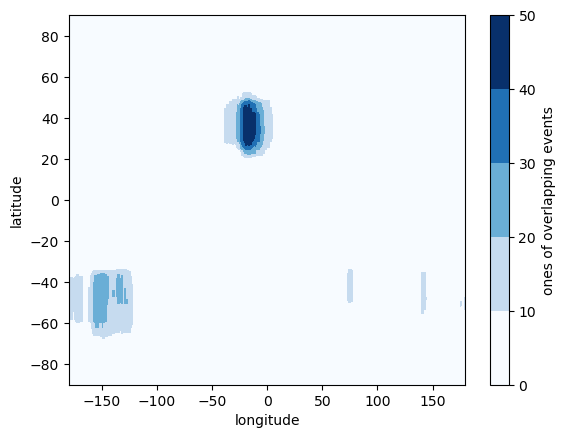

In [13]:
#Plot the anticyclonic wave breaking zones
data_flagged = clim_xarray(f_pt,tracked[tracked.orientation=='anticyclonic'])
data_flagged.plot.contourf(cmap='Blues')

152it [00:00, 19477.99it/s]


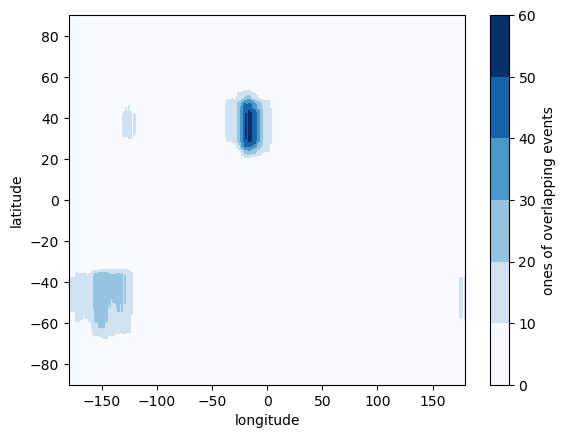

In [14]:
#Plot the wave breaking zones whose tracks are at least 24 hours long
#First select all the tracks where there are at least 4 overturnings in a track (given it is 6 hourly data)
tracked_daily=tracked.groupby(['label']).agg(pd.Series.tolist)
tracked_daily['N']=[len(row.date) for index,row in tqdm(tracked_daily.iterrows())]
tracked_daily=tracked_daily[tracked_daily.N>=4]
daily_labels=tracked_daily.index.tolist()
tracked_daily=tracked[tracked.label.isin(daily_labels)]

#Produce the flagged xarray and plot
data_flagged = clim_xarray(f_pt,tracked_daily)
data_flagged.plot.contourf(cmap='Blues')